# **Modeling and Evaluation (Regression) Notebook**

## Objectives
- Fit and evaluate a regression model to predict the Sales Price for a house in Ames, Iowa

## Inputs
- outputs/data_collected/house_oricing_data.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in notebook 01 - 03.

## Outputs
- Train set
- Test set
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline


---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices'

---

## Step 1: Load data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/data_collected/house_pricing_data.csv")  
  )

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

## Step 2: ML Pipeline with all relevant data

ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection # Import SmartCorrelationSelection
from feature_engine.encoding import OrdinalEncoder # Import OrdinalEncoder
from feature_engine.transformation import LogTransformer  # Import LogTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer # For Imputation
from src.preprocessing import drop_unwanted_columns
import joblib # to import preprocessing.py


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Drop unwanted columns
        ("DropUnwantedFeatures", FunctionTransformer(drop_unwanted_columns, validate=False)),

        # Impute MasVnrArea using mean
        ("ImputeMasVnrArea", MeanMedianImputer(imputation_method='mean', variables=['MasVnrArea'])),

        # Impute missing values in GarageFinish
        ("ImputeGarageFinish", CategoricalImputer(imputation_method='missing', variables=['GarageFinish'])),

        # Encoding categorical variables using OrdinalEncoder, add GarageFinish
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual', 'GarageFinish'])),

         # Feature selection based on correlation using SmartCorrelatedSelection
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=['GarageFinish', 'TotalBsmtSF', 'MasVnrArea', 'OpenPorchSF', '1stFlrSF', 'KitchenQual', 'YearRemodAdd', 'YearBuilt', 'GarageArea'],
         method="spearman", threshold=0.6, selection_method="variance")),

        # Apply log10 transformation to selected numeric features
        # SalePrice is removed due to X_train data
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))

    ], verbose=True)

    return pipeline_base


# Run the pipeline
PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('DropUnwantedFeatures',
                 FunctionTransformer(func=<function drop_unwanted_columns at 0x752846f51080>)),
                ('ImputeMasVnrArea',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MasVnrArea'])),
                ('ImputeGarageFinish',
                 CategoricalImputer(variables=['GarageFinish'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                var...arageFinish'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['GarageFinish',
                                                     'TotalBsmtSF',
                                                     'MasVnrArea',
                                                     'OpenPorchSF', '1stFlrSF',
                                                     'KitchenQual',
                                                     'YearRemodAdd',
                                                     'YearBuilt',
                                                     'GarageArea'])),
                ('LogTransformation',
                 LogTransformer(base='10', variables=['GrLivArea']))],
         verbose=True)

In [6]:
# 1. Get the pipeline
pipeline = PipelineDataCleaningAndFeatureEngineering()

# 2. Fit and transform  DataFrame
df_transformed = pipeline.fit_transform(df)

# 3. View the result
print(df_transformed.head())

[Pipeline]  (step 1 of 6) Processing DropUnwantedFeatures, total=   0.0s
[Pipeline] .. (step 2 of 6) Processing ImputeMasVnrArea, total=   0.0s
[Pipeline]  (step 3 of 6) Processing ImputeGarageFinish, total=   0.0s
[Pipeline]  (step 4 of 6) Processing OrdinalCategoricalEncoder, total=   0.1s
[Pipeline]  (step 5 of 6) Processing SmartCorrelatedSelection, total=   0.0s
[Pipeline] . (step 6 of 6) Processing LogTransformation, total=   0.1s
   BsmtFinSF1  GarageArea  GarageFinish  GrLivArea  KitchenQual  MasVnrArea  \
0         706         548             0   3.232996            0       196.0   
1         978         460             0   3.101059            1         0.0   
2         486         608             0   3.251881            0       162.0   
3         216         642             1   3.234770            0         0.0   
4         655         836             0   3.342028            0       350.0   

   OpenPorchSF  OverallQual  TotalBsmtSF  YearBuilt  SalePrice  
0           61     

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


ML Pipeline for Modelling, import libaries

In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


def PipelineRegressor(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

### Hyperparameter Optimisation

Use GridSearch algorithm to find the best combination of hyperparameters for the model.

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineRegressor(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns]

### Train-test split after transforming the target

X_train and y_train will be used to train the model.
X_test and y_test will be used to evaluate the model.

X set is dropping 'SalePrice' since it is the target variable.
Y contains only the target variable.

In [9]:
from sklearn.model_selection import train_test_split

# Transform target variable
y_log = np.log10(df['SalePrice'])

# Split into features and target
X = df.drop('SalePrice', axis=1) # All columns except 'SalePrice' are features
# y = df['SalePrice'] # 'SalePrice' is the target variable

# Split into train and test sets (80% train, 20% test is common)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)

### Apply the pipeline to training and testing features

In [10]:
pipeline = PipelineDataCleaningAndFeatureEngineering()

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

[Pipeline]  (step 1 of 6) Processing DropUnwantedFeatures, total=   0.0s
[Pipeline] .. (step 2 of 6) Processing ImputeMasVnrArea, total=   0.0s
[Pipeline]  (step 3 of 6) Processing ImputeGarageFinish, total=   0.0s
[Pipeline]  (step 4 of 6) Processing OrdinalCategoricalEncoder, total=   0.0s
[Pipeline]  (step 5 of 6) Processing SmartCorrelatedSelection, total=   0.0s
[Pipeline] . (step 6 of 6) Processing LogTransformation, total=   0.0s
(1168, 10) (1168,) (292, 10) (292,)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype 

* 1168 training samples  and 292 test samples are created

### Check Target Imbalance

Check Target distribution of Train Set --> target shouldn't be imbalance because of the numeric tranformation of sales price (log10)

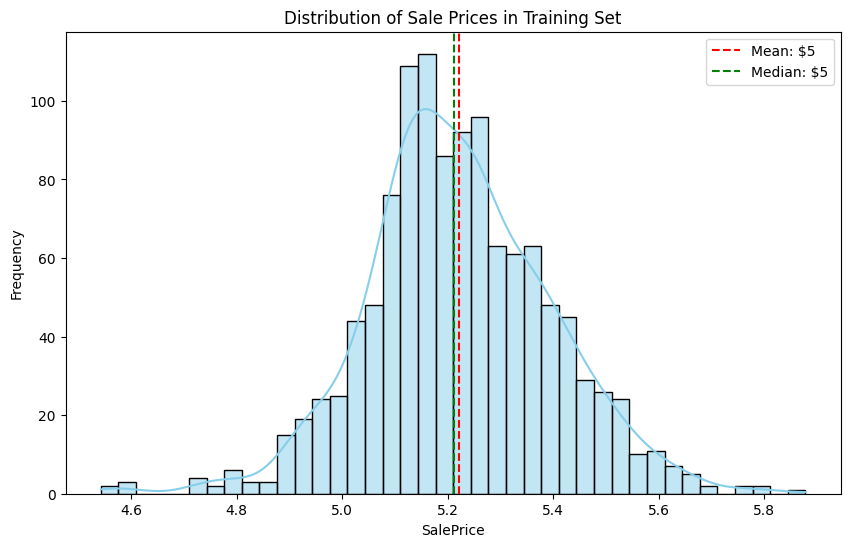

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=40, kde=True, color='skyblue')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():,.0f}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: ${y_train.median():,.0f}')
plt.title("Distribution of Sale Prices in Training Set")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Check Target distribution to show true sale price distribution. Reverse-transform log SalePrice

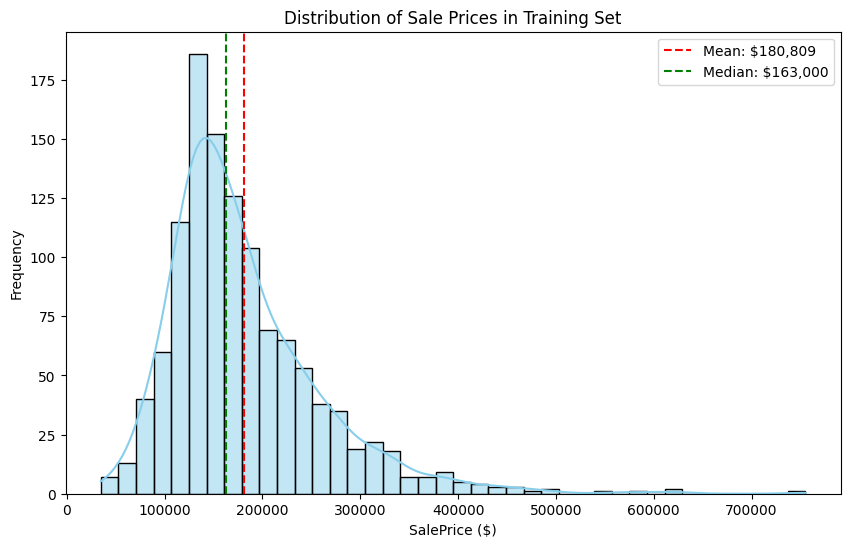

In [13]:
import numpy as np

# Reverse transform log values to actual dollar values
y_train_actual = np.power(10, y_train)

plt.figure(figsize=(10, 6))
sns.histplot(y_train_actual, bins=40, kde=True, color='skyblue')
plt.axvline(y_train_actual.mean(), color='red', linestyle='--', label=f'Mean: ${y_train_actual.mean():,.0f}')
plt.axvline(y_train_actual.median(), color='green', linestyle='--', label=f'Median: ${y_train_actual.median():,.0f}')
plt.title("Distribution of Sale Prices in Training Set")
plt.xlabel("SalePrice ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---

### Hyperparameter Optimization Search (Grid Search)

1. Test multiple algorithms and choose the best one
2. Run multiple hyperparameter on the selected algorithm to identify the best hyperparameter.

#### Test multiple algorithms with Grid Search CV

In [12]:
# Algorithms that will be used/ tested
models_quick_search = {
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

# Define hyperparameter for each algorithm
# empty {} means default hyperparameter will be used
params_quick_search = {
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

Apply algorithms to Train data

In [13]:
from sklearn.metrics import make_scorer, recall_score

# Start HyperparameterOptimizationSeach
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fir model with training data
search.fit(X_train, y_train,
           scoring = 'neg_mean_absolute_error',
           n_jobs=-1, cv=5)

# To check the results:
search.score_summary(sort_by='mean_score')


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,estimator,min_score,mean_score,max_score,std_score
4,ExtraTreesRegressor,-0.062386,-0.056811,-0.050577,0.003993
3,GradientBoostingRegressor,-0.069595,-0.066239,-0.062773,0.002371
0,XGBRegressor,-0.077575,-0.069641,-0.064789,0.004279
2,RandomForestRegressor,-0.075976,-0.072316,-0.066196,0.003315
5,AdaBoostRegressor,-0.079534,-0.076377,-0.065951,0.005239
1,DecisionTreeRegressor,-0.089899,-0.083047,-0.076155,0.004376


A negative mean absolute error (neg_mean_absolute_error) is used as the evaluation metric.

* Lower (negative) MAE values indicate better performance.
* Since the metric is negative, values closer to zero are better.

**First results: (!!?!)**
* ExtraTreesRegressor: Mean score around -0.0052 (best performance).
* GradientBoostingRegressor: Mean score around -0.0056.
* XGBRegressor: Mean score around -0.0058.
* RandomForestRegressor: Mean score around -0.0060.
* AdaBoostRegressor: Mean score around -0.0065.
* DecisionTreeRegressor: Mean score around -0.0070 (lowest performance).

Current results:
First results:
* ExtraTreesRegressor: Mean score around -0.056811 (best performance).
* GradientBoostingRegressor: Mean score around -0.066239
* XGBRegressor: Mean score around -0.069641
* RandomForestRegressor: Mean score around -0.072316
* AdaBoostRegressor: Mean score around -0.076377
* DecisionTreeRegressor: Mean score around -0.083047 (lowest performance).

---

### Define model and parameters, for Extensive Search

Based on the results ExtraTreesRegressor model is the best working on. This one is selected. In the next steps the best hyperparameter set up is defined. 

In [14]:
# Initialize the ExtraTreesRegressor model
model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [15]:
# ExtraTreesRegressor
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

# Define hyperparameter for each algorithm
params_quick_search = {
    "ExtraTreesRegressor": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 20],
        "model__min_samples_split": [2, 5],
    }
}

Apply algorithm and various hyperparameter to test data

In [16]:
from sklearn.metrics import make_scorer, recall_score

# Start HyperparameterOptimizationSeach
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fir model with training data
search.fit(X_train, y_train,
           scoring = 'neg_mean_absolute_error',
           n_jobs=-1, cv=5)

# To check the results:
search.score_summary(sort_by='mean_score')


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
2,ExtraTreesRegressor,-0.060068,-0.054557,-0.048158,0.004059,None,5,100
7,ExtraTreesRegressor,-0.059916,-0.054618,-0.048468,0.003867,20,5,200
6,ExtraTreesRegressor,-0.059997,-0.054628,-0.048385,0.00392,20,5,100
3,ExtraTreesRegressor,-0.060094,-0.054642,-0.048191,0.004049,None,5,200
1,ExtraTreesRegressor,-0.06207,-0.056576,-0.050551,0.003853,None,2,200
5,ExtraTreesRegressor,-0.061982,-0.056667,-0.049719,0.004134,20,2,200
0,ExtraTreesRegressor,-0.062386,-0.056811,-0.050577,0.003993,None,2,100
4,ExtraTreesRegressor,-0.062261,-0.056909,-0.049751,0.004268,20,2,100


Best score, currently: ExtraTreesRegressor 2 (-0.054557)

---

## Define pipeline with the best set up

Model type: 
ExtraTreesRegressor

Hyperparameter: 
* model_max_depth: 20
* model_min_samples_split: 5
* model_n_estimators: 200

In [17]:
from sklearn.ensemble import ExtraTreesRegressor # already imported on top

# Initialize the ExtraTreesRegressor model
pipeline_regressor = ExtraTreesRegressor(
    max_depth=20,
    min_samples_split=5,
    n_estimators=100
)

# Fit the model on the training data
pipeline_regressor.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=20, min_samples_split=5)

### Make Predictions and Evaluate the Model

In [41]:
from sklearn.metrics import mean_absolute_error # already imported on top
from sklearn.metrics import r2_score

# 1. Predict (still in log scale)
y_pred_log = pipeline_regressor.predict(X_test)

# 2. Inverse transform both predictions and test target
y_pred = np.power(10, y_pred_log)
y_test_actual = np.power(10, y_test)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test_actual, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test_actual, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test_actual, y_pred)


print(f"Mean Absolute Error (MAE): ${mae:,.0f}")
print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.0f}")
print(f"R² Score: {r2:.4f}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BsmtFinSF1
- GarageArea
- KitchenQual
- OpenPorchSF
- TotalBsmtSF


Final Evaluation Results (Interpreted):

MAE: $19,926, On average, model's predictions are off by less than $20K. For house prices, that’s acceptable, especially for mid-to-upper priced homes.

RMSE: $34,598, Idea of the “typical” error. It’s only slightly higher than MAE, which suggests that large outliers are not dominating the error.

R² Score: 0.83, Model explains 83% of the variance in sale prices — this is good for a regression problem in real estate, where 70–85% is typically strong.

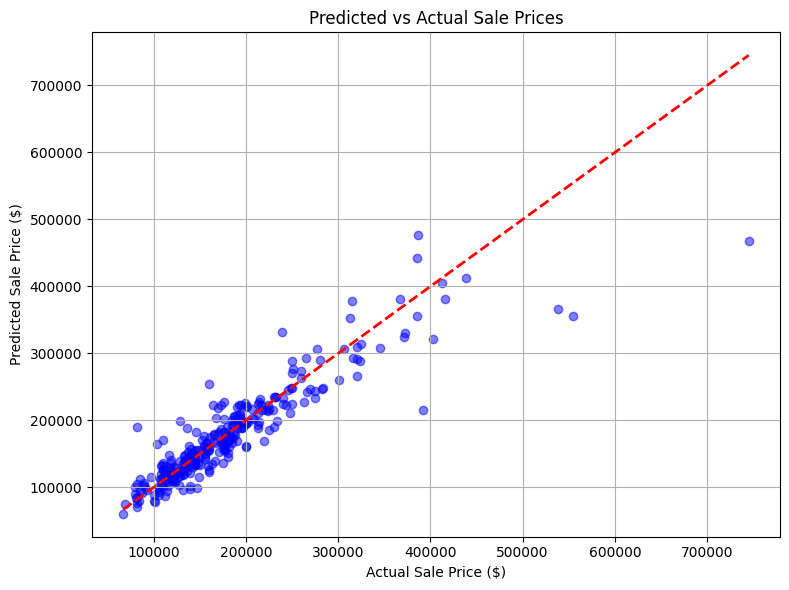

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5, color='blue')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         color='red', lw=2, linestyle='--')  # ideal line

plt.title("Predicted vs Actual Sale Prices")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

---

## Step 3: Refine pipeline with best features

(The pipeline is already optimized and needs only 5 features:
'GarageFinish', 'GrLivArea','MasVnrArea', 'OverallQual', 'YearBuilt'

irrelevant variables:
BsmtFinSF1, GarageArea, KitchenQual, OverallQual, TotalBsmtSF, YearRemodAdd, SalePrice(for x_train and test data)

Clean dataset

In [20]:
print(df_transformed.shape)
df_transformed.head(3)

(1460, 11)


,BsmtFinSF1,GarageArea,GarageFinish,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,706,548,0,3.232996,0,196.0,61,7,856,2003,208500
1,978,460,0,3.101059,1,0.0,0,6,1262,1976,181500
2,486,608,0,3.251881,0,162.0,42,7,920,2001,223500


Delete unwanted variables

In [22]:
df_opt = df_transformed.drop(columns=['BsmtFinSF1', 'KitchenQual', 'OpenPorchSF', 'TotalBsmtSF', 'GarageArea'])

print(df.shape)
df_opt.head(3)

(1460, 24)


,GarageFinish,GrLivArea,MasVnrArea,OverallQual,YearBuilt,SalePrice
0,0,3.232996,196.0,7,2003,208500
1,0,3.101059,0.0,6,1976,181500
2,0,3.251881,162.0,7,2001,223500


In [23]:
df_opt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageFinish  1460 non-null   int64  
 1   GrLivArea     1460 non-null   float64
 2   MasVnrArea    1460 non-null   float64
 3   OverallQual   1460 non-null   int64  
 4   YearBuilt     1460 non-null   int64  
 5   SalePrice     1460 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 68.6 KB


In [24]:
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection # Import SmartCorrelationSelection
from feature_engine.encoding import OrdinalEncoder # Import OrdinalEncoder
from feature_engine.transformation import LogTransformer  # Import LogTransformer
from feature_engine.imputation import MeanMedianImputer # For Imputation
from src.preprocessing import drop_unwanted_columns
import joblib # to import preprocessing.py


def PipelineDataCleaningAndFeatureEngineering_opt():
    pipeline_opt = Pipeline([
        # Function Transformer not needed anymore

        # Impute GarageFinish using mode (most frequent)
        ("ImputeGarageFinish", CategoricalImputer(imputation_method='frequent', variables=['GarageFinish'])),

        # Impute MasVnrArea using mean
        ("ImputeMasVnrArea", MeanMedianImputer(imputation_method='mean', variables=['MasVnrArea'])),

        # Encoding categorical variables using OrdinalEncoder, add GarageFinish
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     #variables=['GarageFinish'])),

        # SmartCorrelatedSelection not needed anymore

        # Apply log10 transformation to selected numeric features
        # SalePrice is removed due to X_train data
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))

    ])

    return pipeline_opt


# Run the pipeline
PipelineDataCleaningAndFeatureEngineering_opt()

Pipeline(steps=[('ImputeGarageFinish',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish'])),
                ('ImputeMasVnrArea',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MasVnrArea'])),
                ('LogTransformation',
                 LogTransformer(base='10', variables=['GrLivArea']))])

### Train-test split after transforming the target

In [32]:
from sklearn.model_selection import train_test_split

# Transform target variable
df_opt['SalePrice'] = np.log10(df_opt['SalePrice'])

# Ensure GarageFinish is treated as categorical
df_opt['GarageFinish'] = df_opt['GarageFinish'].astype('object')

# Split into features and target
X = df_opt.drop('SalePrice', axis=1) # All columns except 'SalePrice' are features
y = df_opt['SalePrice'] # 'SalePrice' is the target variable

# Split into train and test sets (80% train, 20% test is common)
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X, y, test_size=0.2, random_state=0)

### Apply DC and FE pipeline to optimized training and testing features

In [33]:
pipeline_opt = PipelineDataCleaningAndFeatureEngineering_opt()

X_train_opt = pipeline_opt.fit_transform(X_train_opt)
X_test_opt = pipeline_opt.transform(X_test_opt)

print(X_train_opt.shape, y_train_opt.shape, X_test_opt.shape, y_test_opt.shape)

(1168, 5) (1168,) (292, 5) (292,)


### Apply regressor pipeline to optimized training and testing features

In [36]:
# Fit the model on the training data
pipeline_regressor.fit(X_train_opt, y_train_opt)

ExtraTreesRegressor(max_depth=20, min_samples_split=5)

### Evaluate optimized regression pipeline:

In [38]:
from sklearn.metrics import mean_absolute_error # already imported on top
from sklearn.metrics import r2_score

# 1. Predict (still in log scale)
y_pred_opt_log = pipeline_regressor.predict(X_test_opt)

# 2. Inverse transform both predictions and test target
y_pred_opt = np.power(10, y_pred_opt_log)
y_test_opt_actual = np.power(10, y_test_opt)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test_opt_actual, y_pred_opt)  # Mean Absolute Error
mse = mean_squared_error(y_test_opt_actual, y_pred_opt)    # Mean Squared Error
rmse = mean_squared_error(y_test_opt_actual, y_pred_opt, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test_opt_actual, y_pred_opt)


print(f"Mean Absolute Error (MAE): ${mae:,.0f}")
print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.0f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): $22,190
Mean Squared Error (MSE): 1,511,014,712
Root Mean Squared Error (RMSE): $38,872
R² Score: 0.7812


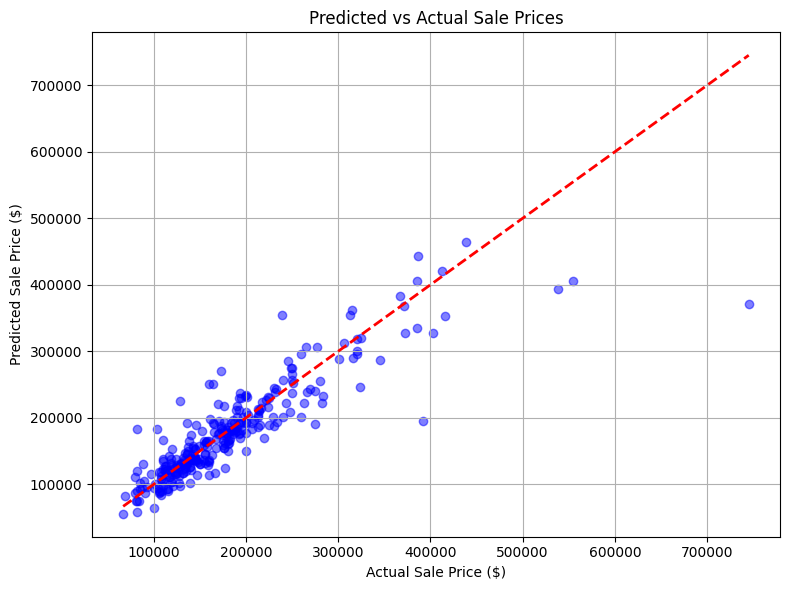

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_opt_actual, y_pred_opt, alpha=0.5, color='blue')
plt.plot([y_test_opt_actual.min(), y_test_opt_actual.max()],
         [y_test_opt_actual.min(), y_test_opt_actual.max()],
         color='red', lw=2, linestyle='--')  # ideal line

plt.title("Predicted vs Actual Sale Prices")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

---

##  Step 4: Push files to Repo

The following files will be generated:
- Train Set
- Test Set
- Data cleaning and Feature Engineering pipeline
- Regressor pipeline

In [29]:
pipeline_dc_fe = pipeline
pipeline_dc_fe_opt = pipeline_opt

In [30]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipelines/predict_SalePrice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# Save trained model
joblib.dump(value=pipeline_dc_fe ,
            filename=f"{file_path}/pipeline_data_cleaning_feat.pkl")
joblib.dump(value=pipeline_dc_fe_opt,
            filename=f"{file_path}/pipeline_data_cleaning_feat_opt.pkl")
joblib.dump(value=pipeline_regressor,
            filename=f"{file_path}/pipeline_regressor.pkl")

[Errno 17] File exists: 'outputs/ml_pipelines/predict_SalePrice/v1'


['outputs/ml_pipelines/predict_SalePrice/v1/pipeline_regressor.pkl']

## Train Set

In [31]:
print(X_train.shape)
X_train.head()

print(X_train_opt.shape)
X_train_opt.head()

(1168, 10)
(1168, 5)


,GarageArea,GrLivArea,MasVnrArea,OverallQual,YearBuilt
618,774,0.513481,452.0,9,2007
870,308,0.470019,0.0,5,1962
92,432,0.474810,0.0,5,1921
817,857,0.508884,148.0,8,2002
302,843,0.503491,150.0,7,2001


In [32]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
X_train_opt.to_csv(f"{file_path}/X_train_opt.csv", index=False)

In [33]:
y_train_opt

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [34]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
y_train_opt.to_csv(f"{file_path}/y_train_opt.csv", index=False)

## Test Set

In [35]:
print(X_test.shape)
X_test.head()

print(X_test_opt.shape)
X_test_opt.head()

(292, 10)
(292, 5)


,GarageArea,GrLivArea,MasVnrArea,OverallQual,YearBuilt
529,484,0.531548,103.685262,6,1957
491,240,0.504893,0.000000,6,1941
459,352,0.488588,161.000000,5,1950
279,505,0.519274,299.000000,7,1977
655,264,0.482620,381.000000,6,1971


In [36]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
X_test_opt.to_csv(f"{file_path}/X_test_opt.csv", index=False)

In [37]:
y_test_opt

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [38]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)
y_test_opt.to_csv(f"{file_path}/y_test_opt.csv", index=False)

---

## Step 5: Combine Data Engineering and Regressor pipeline (in progress)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("outputs/data_collected/house_pricing_data.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Assuming you already have SalePrice
y = df['SalePrice']

# Data cleaning: Drop specified columns and fill missing values for relevant columns
X = X.drop(columns=['BsmtFinType1', 'LotArea', 'BsmtFinType1', 'BsmtUnfSF', 'BedroomAbvGr', 'BsmtExposure', 'OverallCond', 'GarageYrBlt', 'LotFrontage', 'EnclosedPorch', 'WoodDeckSF', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'GarageFinish'])

# Data cleaning: Fill missing values in 'MasVnrArea' column with the mean
X['MasVnrArea'] = X['MasVnrArea'].fillna(X['MasVnrArea'].mean())

# Data cleaning: Ensure the columns to which you will apply the log transformation are float64
X['GrLivArea'] = X['GrLivArea'].astype('float64')

# Define preprocessing steps
preprocessing = Pipeline([
        # Apply log10 transformation to selected numeric features
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))
    ])

# Combine preprocessing with model
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("pipline_regressor", pipeline_regressor)
    # ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('LogTransformation',
                                  LogTransformer(base='10',
                                                 variables=['GrLivArea']))])),
                ('pipline_regressor',
                 ExtraTreesRegressor(max_depth=20, min_samples_split=5))])

---

## Model evaluation

In [ ]:
y_pred = full_pipeline.predict(X_test)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 20681.795260437055
Mean Squared Error (MSE): 969655741.1103821
Root Mean Squared Error (RMSE): 31139.295770944824


Save pipeline

In [ ]:
# Create folder if needed
model_path = "outputs/ml_pipelines/predict_SalePrice/v1"
os.makedirs(model_path, exist_ok=True)

# Save pipeline
joblib.dump(full_pipeline, f"{model_path}/full_pipeline.pkl")

['outputs/ml_pipelines/predict_SalePrice/v1/full_pipeline.pkl']

---

## Visualisatons (in progress)

### Residuals Plot (for Regression Models)

Purpose: To check if residuals (errors) are randomly distributed. This helps in validating assumptions of homoscedasticity in regression models.

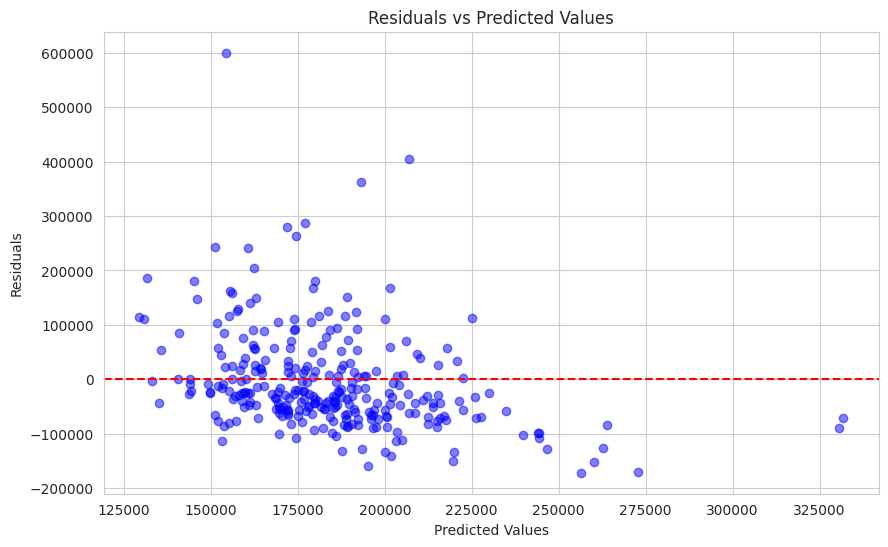

In [ ]:
import matplotlib.pyplot as plt

# Assuming there is a regression model and y_pred provided
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()